In [1]:
import pandas as pd
import numpy as np
import json
import pywt
import random
import matplotlib.pyplot as plt
from scipy.signal import stft, detrend
from scipy.ndimage import uniform_filter1d
from scipy.signal import spectrogram
import librosa
import librosa.display

## ETL: Split Cutting Data into Rotations

In [2]:
# All: 40000 rows, 50%: 20000 rows, 10%: 4000 rows
nr_rows = 4000
df = pd.read_csv('all.csv', nrows=nr_rows)

# Extract torque and angle outside the loop
torque_data = df["Torque"].apply(json.loads)
angle_data = df["Angle"].apply(json.loads)

torque_array = []
whole_rotation = []
first_rotation = []
second_rotation = []

for sample in range(0, nr_rows):
    torque = pd.DataFrame(torque_data[sample][0]['Rows'], columns=["Time", "Torque"])
    torque = torque.drop(columns=["Time"])
    angle = pd.DataFrame(angle_data[sample][0]['Rows'], columns=["Time", "Angle"])

    total_data = pd.concat([angle, torque], axis=1)
    total_data['Kleiner_als_vorher'] = total_data["Angle"] > total_data["Angle"].shift(1)
    total_data['Kumulatives_Produkt'] = (total_data['Kleiner_als_vorher'][1:].astype(int)).cumprod()

    resultat = total_data[total_data['Kumulatives_Produkt'] == 1]
    resultat2 = total_data[total_data['Kumulatives_Produkt'] == 0]
    resultat2 = resultat2.reset_index()

    resultat = resultat.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    resultat2 = resultat2.drop(columns=["Time", "index", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])

    # Ensure both dataframes have the same shape by truncating or padding
    whole_len = 1800
    max_len = 836  # Define the target length
    resultat = resultat.head(max_len).reindex(range(max_len), fill_value=0)
    resultat2 = resultat2.head(max_len).reindex(range(max_len), fill_value=0)


    first_rotation.append(resultat)
    second_rotation.append(resultat2[30:836])

    total_data = total_data.drop(columns=["Time", "Angle", 'Kleiner_als_vorher', "Kumulatives_Produkt"])
    total_data = total_data.head(max_len).reindex(range(whole_len), fill_value=0)
    whole_rotation.append(total_data)

    torque_array.append(torque)

# First Rotation
data = np.array(first_rotation)
squeezed_arr = np.squeeze(data)

# Second Rotation - The rotatiion where Frequencies are different
data2 = np.array(second_rotation)
squeezed_arr2 = np.squeeze(data2)

# Whole Rotation
data3 = np.array(whole_rotation)
whole_rotation_arr = np.squeeze(data3)

In [3]:
# Stats on data
print("Number of sample first rotation = ", len(squeezed_arr))
print("Number of sample second rotation = ", len(squeezed_arr2))

print("Number of sample total= ", len(whole_rotation_arr))

Number of sample first rotation =  4000
Number of sample second rotation =  4000
Number of sample total=  4000


## Mel Spectogram

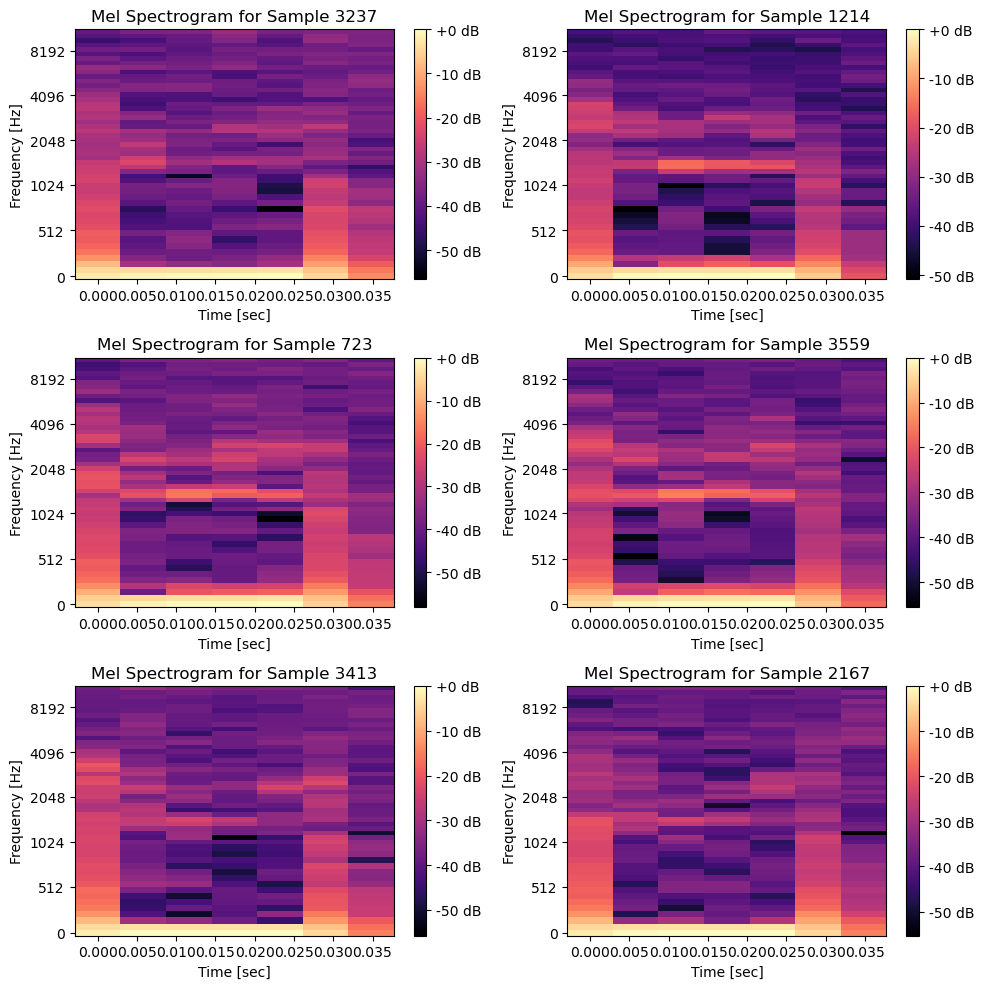

In [4]:
# Define a function to plot the Mel spectrogram of a signal
def plot_mel_spectrogram(data, sr=100, n_fft=256, hop_length=128, n_mels=50, cmap='magma'):
    S = librosa.feature.melspectrogram(y=data, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap=cmap)
    plt.colorbar(format='%+2.0f dB')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Mel Spectrogram')

# Select 6 random samples
random_indices = random.sample(range(squeezed_arr2.shape[0]), 6)

plt.figure(figsize=(10, 10))

# Plot Mel spectrograms for 6 random samples
for i, idx in enumerate(random_indices):
    plt.subplot(3, 2, i + 1)
    plot_mel_spectrogram(squeezed_arr2[idx], sr=22050)
    plt.title(f'Mel Spectrogram for Sample {idx}')

plt.tight_layout()
plt.show()

## Short Time Fourier Transform Spectogram

(4000, 836)


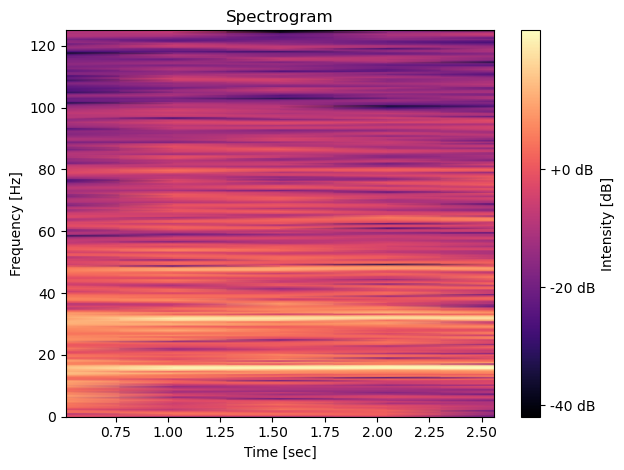

(257, 5)
(4000, 836)


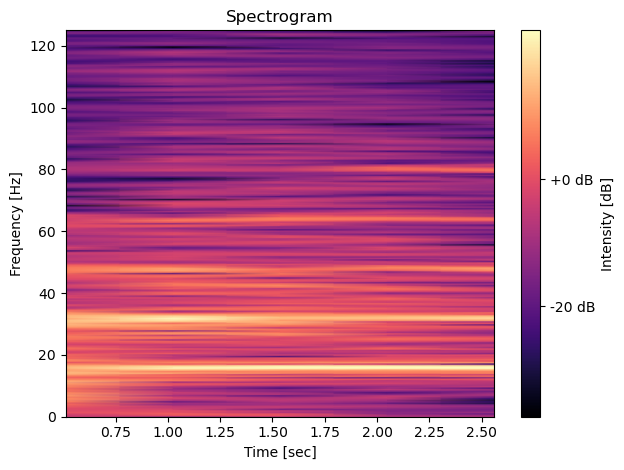

(257, 5)
(4000, 836)


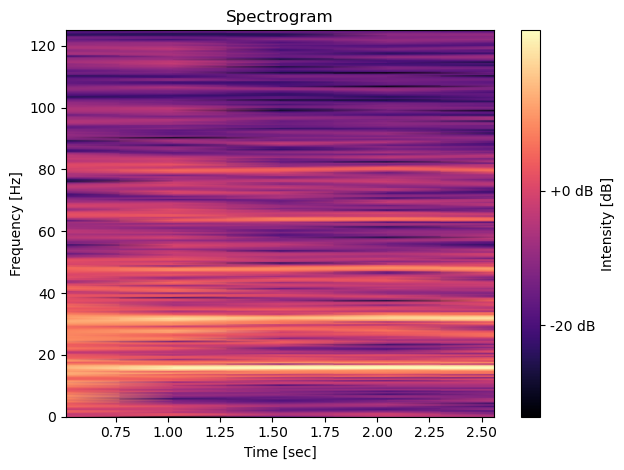

(257, 5)
(4000, 836)


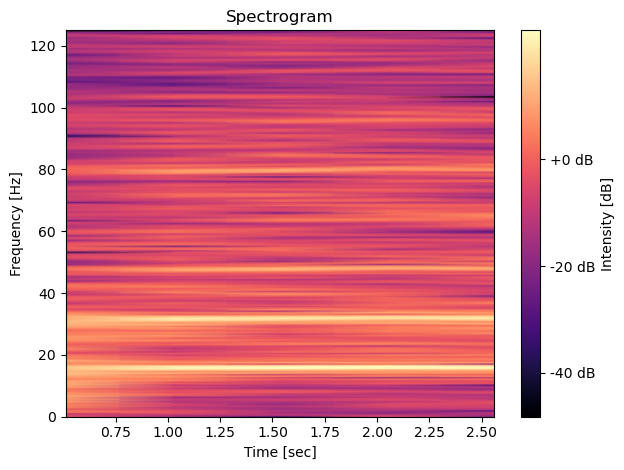

(257, 5)
(4000, 836)


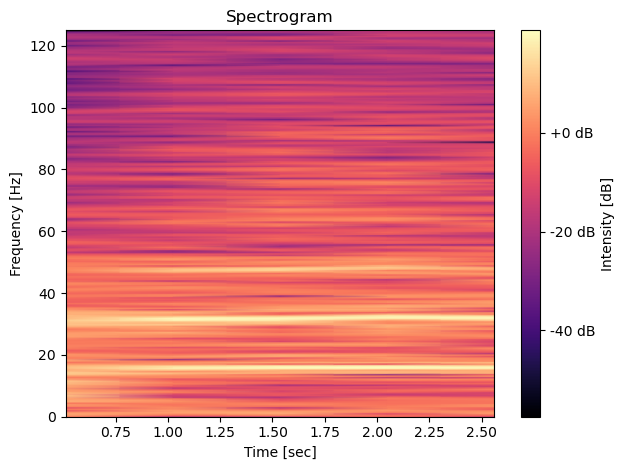

(257, 5)
(4000, 836)


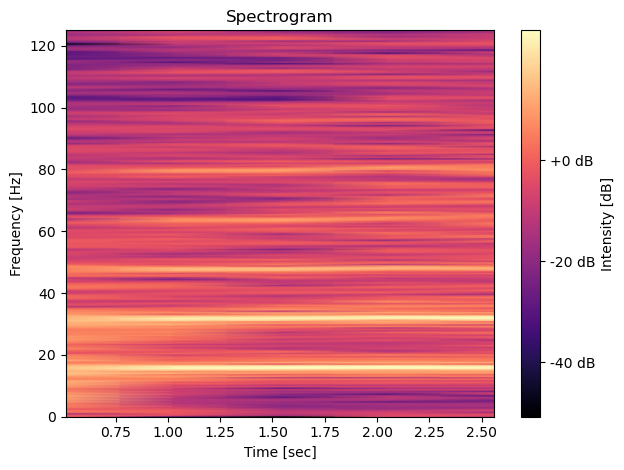

(257, 5)


In [16]:

# Define a function to plot the spectrogram of a signal
def plot_spectrogram(data, fs=250.0, noverlap=128, nperseg=256, nfft=512, cmap='magma'):
    f, t, Sxx = spectrogram(data, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud', cmap=cmap)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]', format='%+2.0f dB', ticks=[-60 + 20 * i for i in range(4)])
    plt.xlim([t[0], t[-1]])
    plt.title('Spectrogram')

    plt.tight_layout()
    plt.show()
    print(Sxx.shape)

# Select 5 random samples
random_indices = random.sample(range(squeezed_arr2.shape[0]), 6)

#plt.figure(figsize=(10, 10))

# Plot spectrograms for 5 random samples
for i, idx in enumerate(random_indices):
    #plt.subplot(3, 2, i + 1)
    print(squeezed_arr.shape)
    plot_spectrogram(squeezed_arr[idx])
    #plt.title(f'Spectrogram for Sample {idx}')


## Show Magnitude Scalogram |Coeffs|

In [6]:
% script true
def plot_scalogram(data, title, wavelet='cmor'):
    scales = np.arange(1, 128)  # Define the range of scales
    coeffs, freqs = pywt.cwt(data, scales, wavelet)
    
    plt.imshow(np.abs(coeffs), extent=[0, len(data), scales[-1], scales[0]], cmap='magma', aspect='auto',
               vmax=np.abs(coeffs).max(), vmin=-np.abs(coeffs).max())
    plt.colorbar(label='Magnitude')
    plt.xlabel('Time (Coefficient Index)')
    plt.ylabel('Scale')
    plt.title(title)

# Select 5 random samples
random_indices = random.sample(range(squeezed_arr2.shape[0]), 6)

plt.figure(figsize=(15, 10))

# Plot wavelet scalograms for 5 random samples
for i, idx in enumerate(random_indices):
    plt.subplot(3, 2, i + 1)
    plot_scalogram(squeezed_arr2[idx], "Magnitude Scalogram of Coefficients")
    plt.title(f'Wavelet Scalogram for Sample {idx}')

plt.tight_layout()
plt.show()


UsageError: Line magic function `%` not found.


## Show Power of Wavelet Scalogram |Coeffs|**2 -- 2nd Rotation


In [ ]:

# Function to compute and plot the magnitude scalogram using wavelet transform
def plot_wavelet_scalogram(data, wavelet='cmor', cmap='magma'):
    scales = np.arange(1, 128)
    coefficients, frequencies = pywt.cwt(data, scales, wavelet)
    power = (abs(coefficients)) ** 2
    plt.imshow(power, extent=[0, data.size, 1, 128], cmap=cmap, aspect='auto', vmax=abs(coefficients).max(), vmin=abs(coefficients).min())
    #plt.yscale('log')
    plt.ylabel('Scale')
    plt.xlabel('Time')
    plt.colorbar(label='Magnitude')
    plt.title('Wavelet Magnitude Scalogram')

# Select 5 random samples - Second Rotation
random_indices = random.sample(range(squeezed_arr2.shape[0]), 6)

plt.figure(figsize=(15, 10))

# Plot wavelet scalograms for 5 random samples
for i, idx in enumerate(random_indices):
    plt.subplot(3, 2, i + 1)
    plot_wavelet_scalogram(squeezed_arr2[idx])
    plt.title(f'Wavelet Scalograms Second Rotation for Sample {idx}')

plt.tight_layout()
plt.show()


    

## Show Magnitude Scalogram -- First Rotation

In [ ]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def plot_scalogram(data, title, wavelet='cmor'):
    scales = np.arange(1, 128)  # Define the range of scales
    coeffs, freqs = pywt.cwt(data, scales, wavelet)
    plt.imshow(np.abs(coeffs), extent=[0, len(data), scales[-1], scales[0]], cmap='magma', aspect='auto', vmax=np.percentile(np.abs(coeffs), 99), vmin=np.percentile(np.abs(coeffs), 1))

    plt.colorbar(label='Magnitude')
    #plt.yscale('log')
    plt.xlabel('Time (Coefficient Index)')
    plt.ylabel('Scale')
    plt.title(title)

# Normalize each time series
normalized_data = np.array([normalize(ts) for ts in squeezed_arr])

# Select 6 random samples - Second Rotation
random_indices = random.sample(range(squeezed_arr.shape[0]), 6)

# Plot first rotation of same indices
plt.figure(figsize=(15, 10))

# Plot wavelet scalograms for 6 random samples
for i, idx in enumerate(random_indices):
    plt.subplot(3, 2, i + 1)
    plot_scalogram(squeezed_arr[idx], f'Wavelet Scalograms First Rotation for Sample {idx}')
    
plt.tight_layout()
plt.show()

## Gramian Angular Field

In [ ]:

# Function to compute Gramian Angular Field
def gramian_angular_field(time_series, method='summation'):
    # Normalize time series
    min_val = np.min(time_series)
    max_val = np.max(time_series)
    scaled_series = (time_series - min_val) / (max_val - min_val)
    # Convert to polar coordinates
    phi = np.arccos(scaled_series)
    if method == 'summation':
        gaf = np.cos(phi[:, None] + phi[None, :])
    elif method == 'difference':
        gaf = np.sin(phi[:, None] - phi[None, :])
    else:
        raise ValueError("Method must be either 'summation' or 'difference'")
    return gaf

# Select 5 random samples
random_indices = random.sample(range(squeezed_arr2.shape[0]), 5)

plt.figure(figsize=(15, 10))

# Plot GAF for 5 random samples
for i, idx in enumerate(random_indices):
    time_series = squeezed_arr2[idx]
    
    gaf_summation = gramian_angular_field(time_series, method='summation')
    gaf_difference = gramian_angular_field(time_series, method='difference')
    
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(gaf_summation, cmap='magma', origin='lower')
    plt.title(f'GASF for Sample {idx}')
    plt.colorbar()
    
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(gaf_difference, cmap='magma', origin='lower')
    plt.title(f'GADF for Sample {idx}')
    plt.colorbar()

plt.tight_layout()
plt.show()

## Markov Transition Field 

In [ ]:
def compute_mtf(time_series, n_bins=10):
    # Discretize the time series into n_bins
    bins = np.linspace(np.min(time_series), np.max(time_series), n_bins)
    digitized = np.digitize(time_series, bins) - 1  # Bins are 0-indexed

    # Compute the transition matrix
    transition_matrix = np.zeros((n_bins, n_bins))
    for (i, j) in zip(digitized[:-1], digitized[1:]):
        transition_matrix[i, j] += 1

    # Normalize the transition matrix
    transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)

    # Map the time series data to the transition matrix to create the MTF
    mtf = transition_matrix[digitized][:, digitized]

    return mtf

# Select 5 random samples
random_indices = random.sample(range(squeezed_arr2.shape[0]), 6)

plt.figure(figsize=(15, 10))

# Plot MTF for 5 random samples
for i, idx in enumerate(random_indices):
    time_series = squeezed_arr2[idx]

    mtf = compute_mtf(time_series)

    plt.subplot(3, 2, i + 1)
    plt.imshow(mtf, cmap='magma', origin='lower')
    plt.title(f'Markov Transition Field for Sample {idx}')
    plt.colorbar()

plt.tight_layout()
plt.show()

## Heatmap Representation

In [ ]:

# Function to compute and plot the STFT as a heatmap
def plot_stft_heatmap(data, fs=1.0, nperseg=256, noverlap=128, nfft=256, cmap='magma'):
    f, t, Zxx = stft(data, fs=fs, nperseg=nperseg, noverlap=noverlap, nfft=nfft)
    plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap=cmap)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity')
    plt.title('STFT Heatmap')
    plt.ylim(0, 0.01)  # Set the y-axis limits to show frequencies between 0 and 0.1 Hz


# Select 5 random samples
random_indices = random.sample(range(squeezed_arr2.shape[0]), 6)

plt.figure(figsize=(15, 10))

# Plot STFT heatmaps for 5 random samples
for i, idx in enumerate(random_indices):
    plt.subplot(3, 2, i + 1)
    plot_stft_heatmap(squeezed_arr2[idx])
    plt.title(f'STFT Heatmap for Sample {idx}')

plt.tight_layout()
plt.show()